In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
import cv2
import os 
import keras
from keras import layers, models
from tensorflow import keras as tfkeras
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm 

2024-06-09 18:40:56.943920: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 18:40:56.944019: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 18:40:57.061033: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
image_size = 128
batch_size = 32
learn_rate = 0.01
epochs = 40
data_dir = "/kaggle/input/plantvillage-dataset/color"
input_folder = "/kaggle/input/plant-disease-test/test_images"
test_images = os.listdir("/kaggle/input/plant-disease-test/test_images")

In [3]:
def read_img(image_data):
    try:
        image = cv2.imread(image_data)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (image_size, image_size))
        image = np.array(image, dtype=np.float32) / 255.0  # Normalize the image
        image = image.reshape(1, image_size, image_size, 3)
        
        return image

    except Exception as e:
        print(f"Error> {e}")

In [4]:
train_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.15,
    subset="training",
    seed=123,
    image_size=(image_size, image_size),
    batch_size=batch_size,
)

val_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.15,
    subset="validation",
    seed=123,
    image_size=(image_size, image_size),
    batch_size=batch_size,
)

Found 54305 files belonging to 38 classes.
Using 46160 files for training.
Found 54305 files belonging to 38 classes.
Using 8145 files for validation.


In [5]:
lencoder = LabelEncoder()

disease_classes = train_data.class_names

enc_classes = lencoder.fit_transform(disease_classes)

encoded_disease_classes = lencoder.classes_

print(encoded_disease_classes)
enc_classes

['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy' 'Blueberry___healthy'
 'Cherry_(including_sour)___Powdery_mildew'
 'Cherry_(including_sour)___healthy'
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
 'Corn_(maize)___Common_rust_' 'Corn_(maize)___Northern_Leaf_Blight'
 'Corn_(maize)___healthy' 'Grape___Black_rot'
 'Grape___Esca_(Black_Measles)'
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)' 'Grape___healthy'
 'Orange___Haunglongbing_(Citrus_greening)' 'Peach___Bacterial_spot'
 'Peach___healthy' 'Pepper,_bell___Bacterial_spot'
 'Pepper,_bell___healthy' 'Potato___Early_blight' 'Potato___Late_blight'
 'Potato___healthy' 'Raspberry___healthy' 'Soybean___healthy'
 'Squash___Powdery_mildew' 'Strawberry___Leaf_scorch'
 'Strawberry___healthy' 'Tomato___Bacterial_spot' 'Tomato___Early_blight'
 'Tomato___Late_blight' 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Target_Spot'
 'Tomato___Tom

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37])

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
# data_augmentation = keras.models.Sequential(
#   [
#     layers.RandomFlip("horizontal",
#                       input_shape=(image_size,
#                                   image_size,
#                                   3)),
#     layers.RandomRotation(0.1),
#     layers.RandomZoom(0.1),
#   ]
# )

In [8]:
disease_clf = models.Sequential(
    [
        layers.Rescaling(1.0 / 255, input_shape=(image_size, image_size, 3)),
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(38, activation="softmax")
    ]
)

# disease_clf.compile(
#     optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
# )

disease_clf.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


disease_clf.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,125,766 (8.11 MB)

 Trainable params: 2,125,766 (8.11 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
%%time

history = disease_clf.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs
)

Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-06-09 18:42:17.228100: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.3048, expected 3.51669
2024-06-09 18:42:17.228168: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.67675, expected 5.88864
2024-06-09 18:42:17.228177: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.43804, expected 5.64992
2024-06-09 18:42:17.228185: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.28496, expected 4.49684
2024-06-09 18:42:17.228193: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.70669, expected 4.91857
2024-06-09 18:

  10/1443 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.0710 - loss: 3.5925

I0000 00:00:1717958539.763148      75 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 671/1443 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.4456 - loss: 2.0631

2024-06-09 18:42:39.256792: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 81920: 2.91506, expected 2.52278
2024-06-09 18:42:39.256873: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 84095: 2.83871, expected 2.44643
2024-06-09 18:42:39.256917: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 87884: 2.9042, expected 2.51192
2024-06-09 18:42:39.256950: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 90752: 2.68398, expected 2.29171
2024-06-09 18:42:39.256966: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 91392: 2.38486, expected 1.99259
2024-06-09 18:42:39.256977: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 91520: 2.17922, expected 1.78694
2024-06-09 18:42:39.257003: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 93952: 2.7647, expected 2.37243
2024-06-09 18:42:39.257017: E

1436/1443 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5499 - loss: 1.6408

2024-06-09 18:42:56.523583: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44: 2.66688, expected 2.28455
2024-06-09 18:42:56.523739: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16323: 2.37479, expected 1.99245
2024-06-09 18:42:56.523751: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16383: 2.7497, expected 2.36736
2024-06-09 18:42:56.523844: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32768: 3.99474, expected 3.23231
2024-06-09 18:42:56.523855: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32769: 6.60108, expected 5.83866
2024-06-09 18:42:56.523868: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32770: 5.91769, expected 5.15527
2024-06-09 18:42:56.523887: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32771: 5.70216, expected 4.93974
2024-06-09 18:42:56.523900: E e

1443/1443 ━━━━━━━━━━━━━━━━━━━━ 78s 26ms/step - accuracy: 0.5506 - loss: 1.6381 - val_accuracy: 0.7614 - val_loss: 0.8505
Epoch 2/40
1443/1443 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7878 - loss: 0.7342 - val_accuracy: 0.8107 - val_loss: 0.7044
Epoch 3/40
1443/1443 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8258 - loss: 0.6126 - val_accuracy: 0.7859 - val_loss: 0.8939
Epoch 4/40
1443/1443 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8320 - loss: 0.6389 - val_accuracy: 0.7929 - val_loss: 0.8217
Epoch 5/40
1443/1443 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8540 - loss: 0.5338 - val_accuracy: 0.7956 - val_loss: 1.0285
Epoch 6/40
1443/1443 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8680 - loss: 0.5260 - val_accuracy: 0.7912 - val_loss: 0.8790
Epoch 7/40
1443/1443 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8676 - loss: 0.5354 - val_accuracy: 0.8228 - val_loss: 1.1435
Epoch 8/40
1443/1443 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8463 - loss: 0.6832 - val_accur

In [10]:
test_accuracy = disease_clf.evaluate(val_data, batch_size=batch_size)

print(
    f"The trained plant leaf disease detection model has an accuracy of {100*test_accuracy[1]:.2f}%"
)

255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5042 - loss: 2.9549
The trained plant leaf disease detection model has an accuracy of 50.76%


In [11]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

Text(0.5, 1.0, 'Training and Validation Accuracy')

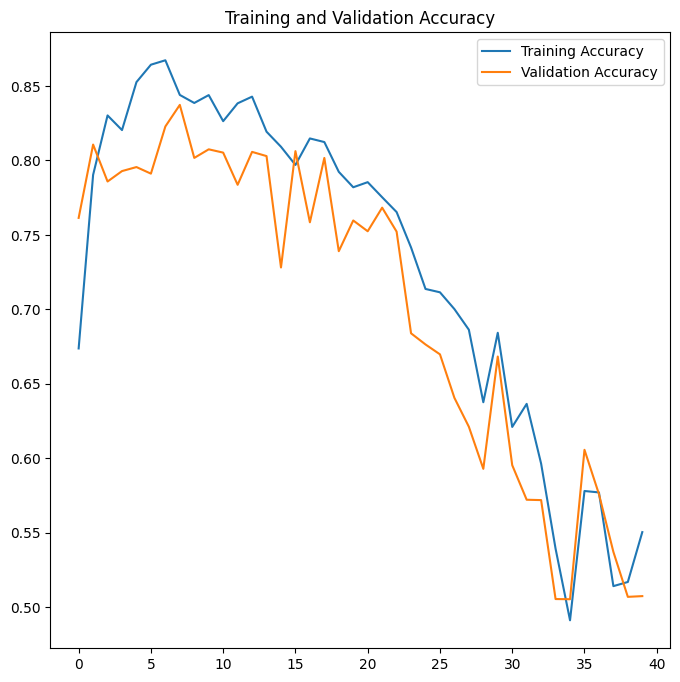

In [12]:
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="upper right")
plt.title("Training and Validation Accuracy")

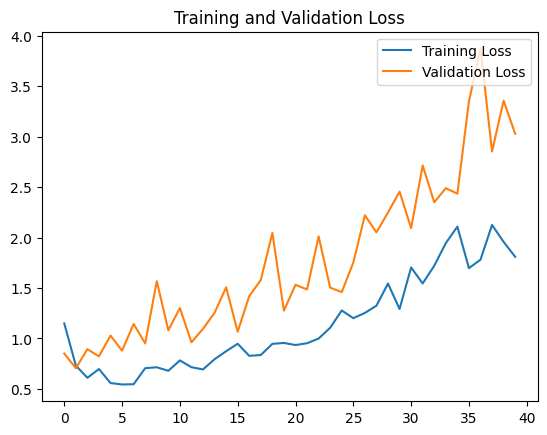

In [13]:
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [14]:
image_list = [os.path.join(input_folder, image_file) for image_file in test_images]

def detect_plant_disease(image: str):
    image = read_img(image)
    class_score = disease_clf.predict(image)
#     print(disease_clf)
    
    predicted_class = np.argmax(class_score)
    certainty = 100 * class_score.max()
    
    return predicted_class, certainty
    
    
for image in tqdm(image_list):
    disease_class, certainty = detect_plant_disease(image)
    print('________________')
    print(f'Input Sentence: {image}')
    print(f'Predicted: {encoded_disease_classes[disease_class]}')
    print(f'Certainty: {certainty:.2f}%')
    print(' ')
    print('________________')

  0%|          | 0/7 [00:00<?, ?it/s]

2024-06-09 18:48:39.246285: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.35916, expected 3.62506
2024-06-09 18:48:39.246350: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.14279, expected 5.4087
2024-06-09 18:48:39.246364: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.55453, expected 4.82044
2024-06-09 18:48:39.246377: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.08747, expected 4.35338
2024-06-09 18:48:39.246394: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 3.96432, expected 3.23023
2024-06-09 18:48:39.246408: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 3.84695, expected 3.11286
2024-06-09 18:48:39.246418: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.1695, expected 4.43541
2024-06-09 18:48:39.246428: E external/local_xla/xla/serv

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
________________
Input Sentence: /kaggle/input/plant-disease-test/test_images/apple_healthy.jpeg
Predicted: Tomato___Late_blight
Certainty: 99.99%
 
________________
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
________________
Input Sentence: /kaggle/input/plant-disease-test/test_images/healthy_tomato_leaf.jpeg
Predicted: Tomato___Late_blight
Certainty: 99.95%
 
________________
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
________________
Input Sentence: /kaggle/input/plant-disease-test/test_images/cornleafnormal.jpeg
Predicted: Peach___Bacterial_spot
Certainty: 100.00%
 
________________
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
________________
Input Sentence: /kaggle/input/plant-disease-test/test_images/tomato_leafdiseas.jpeg
Predicted: Peach___Bacterial_spot
Certainty: 100.00%
 
________________
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
________________
Input Sentence: /kaggle/input/plant-disease-test/test_images/leafrustcorn.jpeg
Predicted: Peach___Bacterial_spo

In [15]:
def predict2(img_file):
    img = tf.keras.utils.load_img(img_file, target_size=(image_size, image_size))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = disease_clf.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
    "This image {} most likely belongs to \n {} ."
    .format(img_file, disease_classes[np.argmax(score)])
    )
    
for image in tqdm(image_list):
    predict2(image)

  0%|          | 0/7 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
This image /kaggle/input/plant-disease-test/test_images/apple_healthy.jpeg most likely belongs to 
 Tomato___Tomato_Yellow_Leaf_Curl_Virus .
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
This image /kaggle/input/plant-disease-test/test_images/healthy_tomato_leaf.jpeg most likely belongs to 
 Corn_(maize)___Common_rust_ .
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
This image /kaggle/input/plant-disease-test/test_images/cornleafnormal.jpeg most likely belongs to 
 Orange___Haunglongbing_(Citrus_greening) .
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
This image /kaggle/input/plant-disease-test/test_images/tomato_leafdiseas.jpeg most likely belongs to 
 Corn_(maize)___Northern_Leaf_Blight .
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
This image /kaggle/input/plant-disease-test/test_images/leafrustcorn.jpeg most likely belongs to 
 Strawberry___Leaf_scorch .
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
This image /kaggle/input/plant-disease-test/test_images/corn_leafdiseased.jpeg most

In [16]:
disease_clf.save("tf_plant_disease_classifier.keras")
disease_clf.save("tf_plant_disease_classifier.h5")

In [17]:
# import tensorflow as tf

# outfile = '/kaggle/working/leaf_disease_clf.tflite'

# converter = tf.lite.TFLiteConverter.from_keras_model(disease_clf)
# tflite_model = converter.convert()

# # Save the model.
# with open(outfile, 'wb') as f:
#     f.write(tflite_model)